# Word Encoding Using LSTMs

Here we will see if we can generate a word encoding using LSTMs.

The idea is that we take tokenised words of the form: ```<W>the</W>``` and feed into an auto-encoder at a character-level. We then take the output of the trained encoder as a word encoder to output a word vector.

In [1]:
# We'll start with some claim 1 data

# Load data
import os
import pickle

In [1]:
with open("raw_data.pkl", "rb") as f:
    data = pickle.load(f)

data[0]

('\n1. A detector for atrial fibrillation or flutter (AF) comprising: \nan impedance measuring unit comprising a measuring input, to which an atrial electrode line having an electrode for a unipolar measurement of an impedance in an atrium is connected and is implemented to generate an atrial impedance signal, obtained in a unipolar manner, in such a way that an impedance signal for each atrial cycle, comprising an atrial contraction and a following relaxation of said atrium, comprises multiple impedance values detected at different instants within a particular atrial cycle; \nsaid impedance measuring unit comprising a signal input, via which a ventricle signal is to be supplied to said detector, which reflects instants of ventricular contractions in chronological assignment to said impedance signal; \nan analysis unit configured to average multiple sequential impedance signal sections of a unipolar atrial impedance signal, which are each delimited by two sequential ventricular contrac

In [2]:
# We'll use spacy for tokenisation etc
import spacy
nlp = spacy.load('en')

# Convert each claim into a spacy 'doc' object
spacy_data = [nlp(d[0]) for d in data]

In [3]:
# First let's look at some statistics regarding our words
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

word_lengths = list()
for doc in spacy_data:
    word_lengths = word_lengths + [len(word) for word in doc]

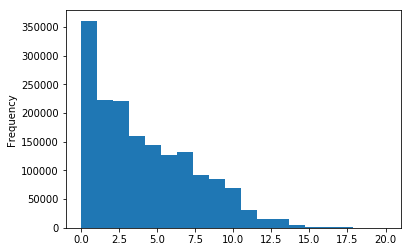

In [4]:
bins = np.linspace(0, 20, 20)
plt.hist(word_lengths, bins)
plt.ylabel('Frequency');

Observation: 

We can probably truncate / split out words at length 15 or 20 and only affect a few words

In [5]:
# We've built a character encoding tool in patentdata we can use to help us
from patentdata.models.chardict import CharDict
cd = CharDict()

In [9]:
# Let's test our character converter
print("Here's 'test' in integers - {0}".format(cd.text2int("test")))

# Let's test our character converter
print("Here's 'Test' in integers - {0}".format(cd.text2int("Test")))

# Let's generate a data set consisting of words in our claim
words = [word for doc in spacy_data for word in doc]

print("There are {0} words".format(len(words)))
print("Here is a sample: {0}".format(words[50:60]))

There are 1685371 words
Here is a sample: [generate, an, atrial, impedance, signal, ,, obtained, in, a, unipolar]


In [10]:
# Each word is a token so we need to remember to use the .text property
type(words[0])

spacy.tokens.token.Token

In [11]:
[cd.startwordint] + cd.text2int(words[0].text) + [cd.endwordint]

[79, 71, 80]

In [12]:
# We need to convert each of our words to character indices and add <W> and </W> indices to the beginning and end
int_words = [[cd.startwordint] + cd.text2int(word.text) + [cd.endwordint] for word in words]

In [13]:
# Let's save our int_words for future use
with open("int_words.pkl", "wb") as f:
    pickle.dump(int_words, f)

In [14]:
# What is the maximum length of our int_words?
max_len = max([len(iw) for iw in int_words])
print("Our longest sequence is {0} integers long".format(max_len))

Our longest sequence is 124 integers long


In [15]:
# Let's build our own truncation routine - we want to split sequences over 20 into several sequences
def limit_length(sequences, limit):
    """ Limits sequences to limit by splitting sequences over limit into sub-sequences."""
    new_seqs = list()
    for seq in sequences:
        if len(seq) > limit:
            cut_seq = seq
            while cut_seq:
                new_seqs.append(cut_seq[:limit])
                cut_seq = cut_seq[limit:]
        else:
            new_seqs.append(seq)
    return new_seqs

In [16]:
int_words_limited = limit_length(int_words, 20)

In [17]:
# What is the maximum length of our int_words?
max_len_limited = max([len(iw) for iw in int_words_limited])
print("Our longest sequence is {0} integers long".format(max_len_limited))

Our longest sequence is 20 integers long


In [18]:
int_words_limited[2]

[79, 50, 80]

In [19]:
# Find out what our maximum integer index is
max_index = max([max(iw) for iw in int_words_limited])

In [20]:
print("The maximum integer value (i.e. char index) is: {0}".format(max_index))

The maximum integer value (i.e. char index) is: 82


Use this post to help remind us of the next bit: https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/

In [21]:
from keras.preprocessing import sequence

X = sequence.pad_sequences(int_words_limited,  padding='post')

Using TensorFlow backend.


In [22]:
X[0]

array([79, 71, 80,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0], dtype=int32)

In [23]:
print("We have {0} word samples".format(len(X)))

We have 1687527 word samples


In [24]:
X_limited = X[:20000]

In [25]:
X_l_one_hot = np.eye(cd.vocabulary_size)[X_limited]
print("Our data has a shape of {0}".format(X_l_one_hot.shape))

Our data has a shape of (20000, 20, 83)


In [26]:
X_l_one_hot[0]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       ..., 
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.]])

This code was not possible because our X is too big!
```
X_one_hot = np.eye(max_index+1)[X]
```
However, I don't think we need to convert X into a one-hot vector.

In [56]:
# Clear some memory
del spacy_data, int_words, int_words_limited, words

Let's just have a think about dimensionality.  

Our RNN output at each time stamp will be a vector of length "num_of_characters", i.e. 82 above.  

Our hidden dimension we can set at 300. (We can experiment with changing this.)  

Our sequence length is fixed to 20. (Again we can experiment with this.)

Okay - now let's have a think about our data for the model.  

We have 1687527 "word" sequences. 

Isn't our input and output data the same?

This is what I need to read: https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html.

Our input data is a a set of sequences where each entry in the sequence is a one-hot array based on the number of characters we are using (83).

The character vocabulary size is fixed for the encoder and decoder. It is independent of the text. 

What are our decoder inputs and outputs?
* decoder input = encoder input (but minus ```</W>```)
* decoder output = decoder input shifted 1 later in time

In [64]:
cd.vocabulary_size

83

In [27]:
# Some hyperparameters - start with those used in this example -
# https://github.com/fchollet/keras/blob/master/examples/lstm_seq2seq.py
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 20000  # Number of samples to train on.

In [28]:
# The number of encoder tokens = number of different characters in our CharDict
num_encoder_tokens = cd.vocabulary_size #= 83
# Our decoder character space equals are encoder character space
num_decoder_tokens = num_encoder_tokens

# Our words are all set to the same max length (20)
max_encoder_seq_length = 20
max_decoder_seq_length = max_encoder_seq_length

In [31]:
encoder_input_data = np.zeros(
    (num_samples, max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (num_samples, max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (num_samples, max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [36]:
for i in range(0, num_samples):
    for t in range(0, max_encoder_seq_length):
        encoder_input_data[i, t, X[i][t]] = 1
        if t < (max_encoder_seq_length - 1):
            # decoder input = encoder input for this autoencoder case but skipping last char
            decoder_input_data[i, t, X[i][t]] = 1
        if t > 0:
            # Shift decoder target get so it is one ahead
            decoder_target_data[i, t-1, X[i][t]] = 1

In [37]:
encoder_input_data[0]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       ..., 
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [2]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

Using TensorFlow backend.


NameError: name 'num_encoder_tokens' is not defined

In [39]:
if os.pat
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

Train on 16000 samples, validate on 4000 samples
Epoch 1/100
16000/16000 [==============================] - 369s - loss: 0.8493 - val_loss: 0.6246
Epoch 2/100
16000/16000 [==============================] - 388s - loss: 0.5625 - val_loss: 0.5541
Epoch 3/100
16000/16000 [==============================] - 396s - loss: 0.4277 - val_loss: 0.3966
Epoch 4/100
16000/16000 [==============================] - 382s - loss: 0.3247 - val_loss: 0.3204
Epoch 5/100
16000/16000 [==============================] - 397s - loss: 0.2482 - val_loss: 0.2423
Epoch 6/100
16000/16000 [==============================] - 372s - loss: 0.1890 - val_loss: 0.2018
Epoch 7/100
16000/16000 [==============================] - 369s - loss: 0.1428 - val_loss: 0.1765
Epoch 8/100
16000/16000 [==============================] - 377s - loss: 0.1097 - val_loss: 0.1414
Epoch 9/100
16000/16000 [==============================] - 470s - loss: 0.0843 - val_loss: 0.1245
Epoch 10/100
16000/16000 [==============================] - 421s - lo

I can actually test the model on words in X that are beyond index 20,000 (we had to limit for training to avoid memory errors).

In [ ]:
from keras.models import load_model

mo

In [ ]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [ ]:
# We can tweak this function to use our character dictionary
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, cd.startwordint] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = cd.int2char(sampled_token_index)
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_token_index == cd.endwordint or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

#### Extensions
* Bi-directional LSTM for encoding and decoding (have an additional layer to resolve differences on decoder output).
* CNN on input as additional vector portion to capture structure that is spatially invariant across the 1D character stream.
* Use character embeddings rather than one hot vectors.
* See if any faster without loss of accuracy with GRU.

Once I have a trained encoder and decoder I can use these to generate a word vector and to decode that word vector.  

I can then start looking at sequences of word vectors, e.g. sentences.  

Some thoughts:
* From spacy I also have lots of other cool labels, such as POS and dependency tree information. I want to jointly optimise to predict not only the next word vector in a sequence but the next POS etc label.
* I can then generate sentence embeddings with shorter sequences, i.e. I can repeat the mthods above to generate a claim encoding. I can then try this on my classification model and my claim-to-title models.
* On the claim-to-title models I can predict sequences of word vectors and then decode these to provide an output.